# Sentence Embeddings Comparision

source: https://towardsdatascience.com/detecting-document-similarity-with-doc2vec-f8289a9a7db7

Intuitively, one would expect documents belonging to the same category to be more similar to each other than to documents belonging to other categories. And that’s exactly the metric we’re going to judge our model by; a good model should give higher similarity values for documents of the same category than for cross-category documents. <br>
The first thing we’ll do is create sets of document pairs for all categories. More specifically, given our four categories, which we’ll denote by C₁,..,C₄, where each category is a set of documents, we get the following category pairs: <br> <br>
(C₁, C₁), (C₁, C₂), (C₁, C₃), (C₁, C₄)<br>
(C₂, C₂), (C₂, C₃), (C₂, C₄)<br>
(C₃, C₃), (C₃, C₄)<br>
(C₄, C₄)<br>

<br>

A pair (Ca, Cb) corresponds to the Cartesian product of the set containing all documents in category a and the set containing all documents in category b. More formally: <br><br>

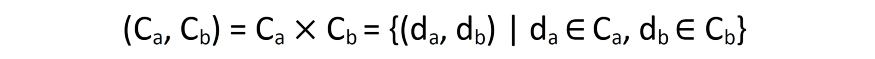

Now, for each document pair, we calculate the documents’ similarity. This results, for each category pair, in a matrix of values between 0 and 1 (one value for each document pair).

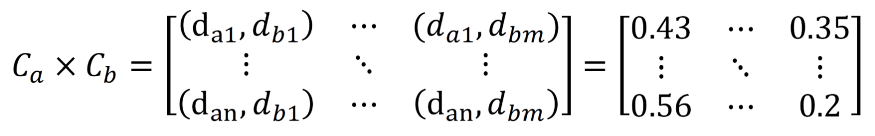

Since we’re using these matrices to judge how similar the documents in two categories are overall, it would certainly make our job a whole lot easier to condense all the values in a matrix into a single value that acts as a measure of similarity. So what we’ll do for each matrix is add up all values inside it to get a single value, which we’ll call similarity total then divide this value by the total number of elements in the matrix to get an average similarity value. <br>

Remember that we’re judging our model not by how similar it tells us documents from the same category are, but rather how much more similar these same-category documents are to each other than to documents from other categories. So the value we’re really after is not only how high the average similarity of, say, (C₃, C₃) is, but rather how high it is relative to the average similarities of (C₁, C₃), (C₂, C₃), and (C₃, C₄). <br>
So given our four categories, this leaves us with four average similarities per category; one for same-category documents and three for cross-category documents. <br>
Here’s what we’re going to do for each category. Using each category’s four average similarity values, we’ll calculate the mean similarity differences between the cross-category average similarities and the same-category average similarity. More formally:

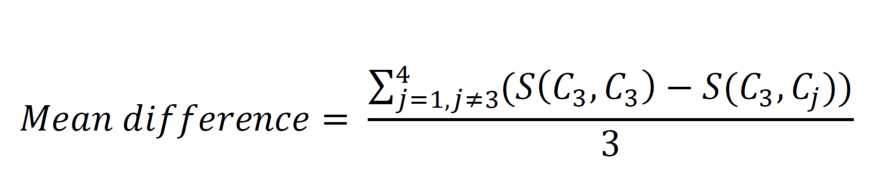

A higher mean difference tells us the model is able to recognize that a certain category’s documents are more distinct from other categories’ documents. Of course, this may not always be the case if a category’s documents really are similar to those of another category.

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim
from gensim.models.doc2vec import Doc2Vec
from tqdm import tqdm
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
import ast
import logging
import json
from sentence_transformers import SentenceTransformer
from nltk.corpus import stopwords 
import re
from gensim.models import Word2Vec 
from gensim.models import KeyedVectors
from nltk.tokenize import RegexpTokenizer

from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sn

stop_words = set(stopwords.words('english'))

logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [4]:
def get_sentence_embeddings(sentence, new_model, base_model):
    word_embeddings = []
    for word in set(sentence):
        if word in new_model:
            word_emb = list(new_model[word])
            word_embeddings.append(word_emb)
        elif word in base_model:
            word_emb = list(base_model[word]) 
            word_embeddings.append(word_emb)
        else:
            continue
            
    word_embeddings = np.array(word_embeddings)
    
    if word_embeddings.shape[0] == 0:
        sentence_embedding = list(np.random.uniform(-1, 1, 300))
    else:
        sentence_embedding = list(np.mean(word_embeddings, axis = 0))
    
    return sentence_embedding

def tokenize(text, stopwords, max_len = 20):
    return [token for token in gensim.utils.simple_preprocess(text, max_len=max_len) if token not in stopwords]

In [5]:
dataset = pd.read_csv('./data/papers_dataset.csv')
dataset.keywords = dataset.keywords.apply(ast.literal_eval)
dataset.sections = dataset.sections.apply(ast.literal_eval)

with open('./data/categories.json', 'r') as f:
    categ_id = json.load(f)

test_df = dataset[dataset.partition == 'test']

all_sentences = []
categories = []
tags = []
paper_ids = []
section_names = []

for _, row in tqdm(test_df.iterrows()):
    cat = row['category']
    
    #abstract_text = ''.join([i for i in row['abstract'] if not i.isdigit()])
    abstract_sents = sent_tokenize(row['abstract'])
    
    all_sentences += abstract_sents
    categories += [cat] * len(abstract_sents)
    paper_ids += [row['paper_id']] * len(abstract_sents)
    section_names += ['abstract'] * len(abstract_sents)
    tags += [row['paper_id'] + '_abstract_' + str(i) for i in range(len(abstract_sents))]
    
    for key, section in row['sections'].items():
        #section_text = ''.join([i for i in section if not i.isdigit()])
        section_sents = sent_tokenize(section)
        
        all_sentences += section_sents
        categories += [cat] * len(section_sents)
        paper_ids += [row['paper_id']] * len(section_sents)
        section_names += [key] * len(section_sents)
        
        tags += [row['paper_id'] + '_' + key.lower().replace(' ', '_') + '_' + str(i) for i in range(len(section_sents))]
        
sent_df = pd.DataFrame({'paper_id': paper_ids, 'section': section_names, 'sentence': all_sentences, 
                        'category': categories, 'tag': tags})
sent_df = sent_df[sent_df.sentence.apply(lambda x: len(x) > 2)]
#sent_df['tokenized_sentence'] = sent_df.sentence.apply(lambda x: tokenize(x, [], max_len=200))

sent_df['categ_id'] = [categ_id[i] for i in sent_df.category.values]

sent_df = sent_df[sent_df.sentence.apply(lambda x: len(word_tokenize(re.sub('[^A-Za-z0-9 ]+', '', x))) > 3)]

36it [00:00, 134.85it/s]


In [6]:
sent_df.shape

(4008, 6)

In [54]:
sent_df

,paper_id,section,sentence,category,tag,categ_id
0,paper_1,abstract,"Through Social media, people are able to write...",Artificial Intelligence,paper_1_abstract_0,0
1,paper_1,abstract,Through these messages also called status upda...,Artificial Intelligence,paper_1_abstract_1,0
2,paper_1,abstract,Tweets and other updates have become so import...,Artificial Intelligence,paper_1_abstract_2,0
3,paper_1,abstract,They enable interaction among vast groups of p...,Artificial Intelligence,paper_1_abstract_3,0
4,paper_1,abstract,These numerous amounts of information can be e...,Artificial Intelligence,paper_1_abstract_4,0
5,paper_1,abstract,This paper reports on the successful developme...,Artificial Intelligence,paper_1_abstract_5,0
6,paper_1,abstract,This helps in solving the problem of losing vi...,Artificial Intelligence,paper_1_abstract_6,0
7,paper_1,abstract,It addresses this limitation by using the data...,Artificial Intelligence,paper_1_abstract_7,0
8,paper_1,Introduction,Clustering is a descriptive task of data mining.,Artificial Intelligence,paper_1_introduction_0,0
9,paper_1,Introduction,A cluster is a collection of data objects that...,Artificial Intelligence,paper_1_introduction_1,0


## Doc2vec

In [94]:
doc2vec_model = Doc2Vec.load('./doc2vec/doc2vec.model')

INFO - 01:54:02: loading Doc2Vec object from ./doc2vec/doc2vec.model
INFO - 01:54:06: loading dv recursively from ./doc2vec/doc2vec.model.dv.* with mmap=None
INFO - 01:54:06: loading wv recursively from ./doc2vec/doc2vec.model.wv.* with mmap=None
INFO - 01:54:06: setting ignored attribute cum_table to None
INFO - 01:54:07: Doc2Vec lifecycle event {'fname': './doc2vec/doc2vec.model', 'datetime': '2021-05-24T01:54:07.464651', 'gensim': '4.0.1', 'python': '3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'loaded'}


In [95]:
doc2vec_embeddings = []

for sentence in tqdm(sent_df.sentence.values):
    test_sent = tokenize(sentence.lower(), stop_words)
    test_sent_vector = doc2vec_model.infer_vector(test_sent)
    doc2vec_embeddings.append(test_sent_vector)

100%|█████████████████████████████████████████████████████████████████████████████| 4008/4008 [00:25<00:00, 160.08it/s]


In [96]:
sent_df['doc2vec_emb'] = doc2vec_embeddings

In [97]:
sent_df.head()

,paper_id,section,sentence,category,tag,categ_id,doc2vec_emb,sent_transf_emb,word2vec_emb,tsne_doc2vec
0,paper_1,abstract,"Through Social media, people are able to write...",Artificial Intelligence,paper_1_abstract_0,0,"[0.30976176, 0.49031082, 0.27335396, -0.580271...","[0.9923173, 0.08931459, -0.34090334, -0.693805...","[0.25343436, 0.012410109, -0.34438372, 0.30190...","[-0.8505111, -7.2797203]"
1,paper_1,abstract,Through these messages also called status upda...,Artificial Intelligence,paper_1_abstract_1,0,"[0.75425667, 0.490113, -0.12403436, -0.4832726...","[0.63820654, 0.23517299, 0.16850387, -0.431451...","[0.11073734, 0.06362086, -0.29996228, 0.133115...","[1.2010022, -4.354437]"
2,paper_1,abstract,Tweets and other updates have become so import...,Artificial Intelligence,paper_1_abstract_2,0,"[0.94475085, -0.5085563, 0.7102081, 0.6202967,...","[0.35303938, -0.19263175, 0.4756388, 0.1927203...","[0.21838884, -0.055159472, -0.29618284, -0.001...","[-1.0608782, -5.988705]"
3,paper_1,abstract,They enable interaction among vast groups of p...,Artificial Intelligence,paper_1_abstract_3,0,"[-0.009392332, 0.072088264, 0.47081774, 0.4559...","[0.4415043, 0.5144025, 0.5956476, -0.66265583,...","[0.19002156, 0.15716586, -0.09866961, 0.398576...","[28.612574, 7.3526287]"
4,paper_1,abstract,These numerous amounts of information can be e...,Artificial Intelligence,paper_1_abstract_4,0,"[-0.685578, 0.42245045, 0.29489163, 0.9557202,...","[-0.4566416, 0.14094177, -0.42779383, 0.776283...","[0.054914843, 0.056703757, -0.25033298, 0.1371...","[-3.8221235, -1.8352525]"


## Sentence Transformer

In [11]:
sent_transf_model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

INFO - 23:15:46: Load pretrained SentenceTransformer: distilbert-base-nli-stsb-mean-tokens
INFO - 23:15:46: Did not find folder distilbert-base-nli-stsb-mean-tokens
INFO - 23:15:46: Search model on server: http://sbert.net/models/distilbert-base-nli-stsb-mean-tokens.zip
INFO - 23:15:46: Load SentenceTransformer from folder: C:\Users\User/.cache\torch\sentence_transformers\sbert.net_models_distilbert-base-nli-stsb-mean-tokens
INFO - 23:16:14: Use pytorch device: cpu


In [12]:
embeddings = sent_transf_model.encode(sent_df.sentence.values)

Batches:   0%|          | 0/126 [00:00<?, ?it/s]

In [13]:
sent_df['sent_transf_emb'] = list(embeddings)

In [66]:
sent_df.head()

,paper_id,section,sentence,category,tag,categ_id,doc2vec_emb,sent_transf_emb
0,paper_1,abstract,"Through Social media, people are able to write...",Artificial Intelligence,paper_1_abstract_0,0,"[-0.40725866, 0.2803913, -0.08426534, 0.244231...","[0.9923173, 0.08931459, -0.34090334, -0.693805..."
1,paper_1,abstract,Through these messages also called status upda...,Artificial Intelligence,paper_1_abstract_1,0,"[0.81689215, 0.5162444, -0.33929557, 0.726768,...","[0.63820654, 0.23517299, 0.16850387, -0.431451..."
2,paper_1,abstract,Tweets and other updates have become so import...,Artificial Intelligence,paper_1_abstract_2,0,"[0.35033023, 0.3265611, -1.0772722, -0.1646334...","[0.35303938, -0.19263175, 0.4756388, 0.1927203..."
3,paper_1,abstract,They enable interaction among vast groups of p...,Artificial Intelligence,paper_1_abstract_3,0,"[0.29673135, 0.034926455, -0.5687106, 0.356286...","[0.4415043, 0.5144025, 0.5956476, -0.66265583,..."
4,paper_1,abstract,These numerous amounts of information can be e...,Artificial Intelligence,paper_1_abstract_4,0,"[0.09422329, 0.60798764, -0.08311775, 0.761239...","[-0.4566416, 0.14094177, -0.42779383, 0.776283..."


## Word2vec

In [14]:
base_model = KeyedVectors.load_word2vec_format('./Fine-Tuning-Word2Vec-Embeddings/GoogleNews-vectors-negative300.bin', 
                                               binary=True)
new_model = KeyedVectors.load_word2vec_format("./Fine-Tuning-Word2Vec-Embeddings/new_word2vec.model")

INFO - 23:23:15: loading projection weights from ./Fine-Tuning-Word2Vec-Embeddings/GoogleNews-vectors-negative300.bin
INFO - 23:24:23: KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from ./Fine-Tuning-Word2Vec-Embeddings/GoogleNews-vectors-negative300.bin', 'binary': True, 'encoding': 'utf8', 'datetime': '2021-05-23T23:24:23.351202', 'gensim': '4.0.1', 'python': '3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'load_word2vec_format'}
INFO - 23:24:32: loading projection weights from ./Fine-Tuning-Word2Vec-Embeddings/new_word2vec.model
INFO - 23:25:01: KeyedVectors lifecycle event {'msg': 'loaded (29222, 300) matrix of type float32 from ./Fine-Tuning-Word2Vec-Embeddings/new_word2vec.model', 'binary': False, 'encoding': 'utf8', 'datetime': '2021-05-23T23:25:01.750244', 'gensim': '4.0.1', 'python': '3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]', 'platform': 'Wind

In [15]:
sentences = sent_df.sentence.values

tokenizer = RegexpTokenizer(r'\w+')
sentences_tokenized = [re.sub(r'\[.*?\]', '', re.sub(r'\d+', '', sent)).lower() for sent in sentences]
sentences_tokenized = [tokenizer.tokenize(sent) for sent in sentences_tokenized]
sentences_tokenized = [[w for w in sentence if not w in stop_words] for sentence in sentences_tokenized]

In [16]:
len(sentences_tokenized)

4008

In [17]:
word2vec_embeddings = [get_sentence_embeddings(tok_sentence, new_model, base_model) 
                       for tok_sentence in sentences_tokenized]

In [18]:
len(word2vec_embeddings), len(word2vec_embeddings[0])

(4008, 300)

In [19]:
sent_df['word2vec_emb'] = word2vec_embeddings

In [112]:
sent_df['doc2vec_emb'] = sent_df['doc2vec_emb'].apply(list)
#sent_df['sent_transf_emb'] = sent_df['sent_transf_emb'].apply(list)

In [227]:
sent_df.head()

,paper_id,section,sentence,category,tag,categ_id,doc2vec_emb,sent_transf_emb,word2vec_emb
0,paper_1,abstract,"Through Social media, people are able to write...",Artificial Intelligence,paper_1_abstract_0,0,"[-0.40725866, 0.2803913, -0.08426534, 0.244231...","[0.9923173, 0.08931459, -0.34090334, -0.693805...","[0.25343436, 0.012410113, -0.34438372, 0.30190..."
1,paper_1,abstract,Through these messages also called status upda...,Artificial Intelligence,paper_1_abstract_1,0,"[0.81689215, 0.5162444, -0.33929557, 0.726768,...","[0.63820654, 0.23517299, 0.16850387, -0.431451...","[0.11073734, 0.06362086, -0.2999623, 0.1331159..."
2,paper_1,abstract,Tweets and other updates have become so import...,Artificial Intelligence,paper_1_abstract_2,0,"[0.35033023, 0.3265611, -1.0772722, -0.1646334...","[0.35303938, -0.19263175, 0.4756388, 0.1927203...","[0.21838886, -0.055159464, -0.29618284, -0.001..."
3,paper_1,abstract,They enable interaction among vast groups of p...,Artificial Intelligence,paper_1_abstract_3,0,"[0.29673135, 0.034926455, -0.5687106, 0.356286...","[0.4415043, 0.5144025, 0.5956476, -0.66265583,...","[0.19002156, 0.15716586, -0.09866961, 0.398576..."
4,paper_1,abstract,These numerous amounts of information can be e...,Artificial Intelligence,paper_1_abstract_4,0,"[0.09422329, 0.60798764, -0.08311775, 0.761239...","[-0.4566416, 0.14094177, -0.42779383, 0.776283...","[0.054914836, 0.056703765, -0.25033298, 0.1371..."


In [113]:
sent_df.to_csv('./data/test_sentence_embeddings.csv', index = False)

## Paper embeddings

In [98]:
paper_ids = []
categs = []
paper_doc2vec_embs = []
paper_sent_transf_embs = []
paper_word2vec_embs = []


for p_id in tqdm(set(sent_df.paper_id.values)):
    paper_df = sent_df[sent_df.paper_id == p_id]
    paper_ids.append(p_id)
    categs.append(paper_df.iloc[0].category)
    paper_doc2vec_embs.append(list(np.mean(np.array([list(i) for i in paper_df.doc2vec_emb.values]), axis = 0)))
    paper_sent_transf_embs.append(list(np.mean(np.array([list(i) for i in paper_df.sent_transf_emb.values]), axis = 0)))
    paper_word2vec_embs.append(list(np.mean(np.array([list(i) for i in paper_df.word2vec_emb.values]), axis = 0)))

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.07it/s]


In [99]:
paper_df = pd.DataFrame({'paper_id': paper_ids, 'category': categs, 'categ_id': [categ_id[i] for i in categs],
                         'doc2vec_emb': paper_doc2vec_embs, 'sent_transf_emb': paper_sent_transf_embs, 
                         'word2vec_emb': paper_word2vec_embs}).sort_values(['category', 'paper_id'])

In [100]:
paper_df.head()

,paper_id,category,categ_id,doc2vec_emb,sent_transf_emb,word2vec_emb
11,paper_1,Artificial Intelligence,0,"[0.050839957, -0.17213674, 0.23190843, 0.02643...","[-0.09093456, 0.000614611, 0.049798097, 0.0543...","[-0.011465008, -0.016940933, -0.072285354, 0.1..."
35,paper_2,Artificial Intelligence,0,"[-0.2791102, 0.30293778, 0.021145811, 0.164245...","[-0.19948675, -0.102212995, 0.47618103, 0.0200...","[0.013730831, -0.022709256, 0.041490473, 0.040..."
3,paper_3,Artificial Intelligence,0,"[-0.056833405, -0.22562754, 0.02680474, -0.190...","[-0.44426557, 0.19895671, 0.21370257, -0.05385...","[0.062326323, -0.101998195, -0.06966386, 0.107..."
28,paper_21,Computer Science and Technology,9,"[-0.13457291, -0.118986934, 0.24787177, 0.0248...","[-0.12950428, 0.18011193, 0.41708615, 0.350887...","[-0.11120842, 0.0058470774, 0.113423385, 0.113..."
14,paper_31,Computer Science and Technology,9,"[-0.021182425, -0.09881289, 0.2015112, 0.26065...","[-0.2120824, -0.07203572, 0.5014954, -0.062110...","[-0.047754277, -0.012471129, -0.12649596, 0.06..."


In [101]:
def documents_similarity(categ_1, categ_2, embedding_col):
    categ_1_papers = list(map(list, paper_df[paper_df.categ_id == categ_1][embedding_col].values))
    categ_2_papers = list(map(list, paper_df[paper_df.categ_id == categ_2][embedding_col].values))
    
    return np.mean(cosine_similarity(categ_1_papers, categ_2_papers))

## Similarity matrix (Doc2vec)

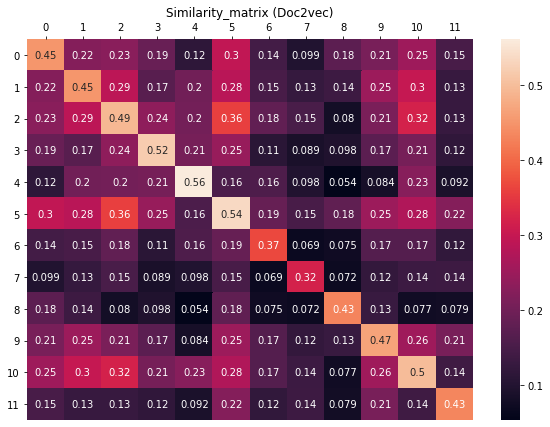

In [102]:
sim_matrix_doc2vec = np.empty(shape = (12, 12))

for i in range(12):
    for j in range(12):
        sim_matrix_doc2vec[i][j] = documents_similarity(i, j, 'doc2vec_emb')
        
plt.figure(figsize = (10, 7))
ax = sn.heatmap(sim_matrix_doc2vec, annot = True)

plt.yticks(rotation=0)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
plt.title('Similarity_matrix (Doc2vec)')
plt.show()

In [103]:
from sklearn.manifold import TSNE

embeddings = np.array(list(map(list, sent_df['doc2vec_emb'].values)))
print(embeddings.shape)
tsne = TSNE(n_components=2)
tsne_emb = tsne.fit_transform(embeddings)

(4008, 100)


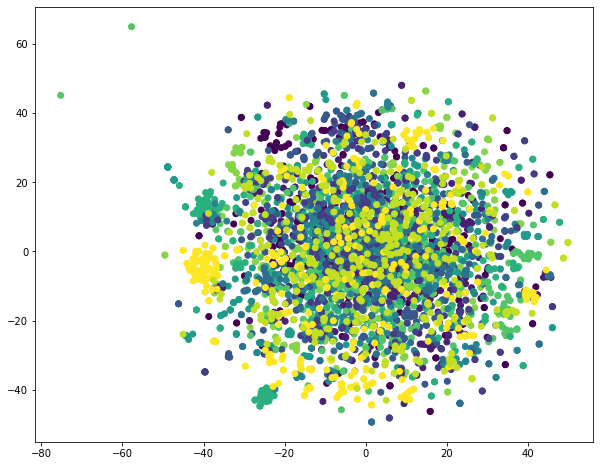

In [104]:
plt.figure(figsize = (10, 8))
plt.scatter(tsne_emb[:, 0], tsne_emb[:, 1], c = sent_df.categ_id.values);

## Similarity matrix (Sentence Transformer)

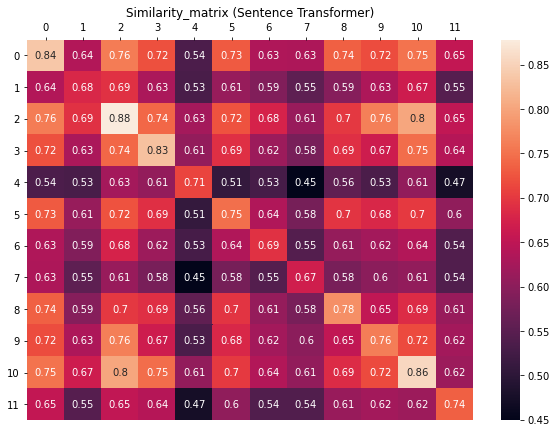

In [86]:
sim_matrix_sent_transf = np.empty(shape = (12, 12))

for i in range(12):
    for j in range(12):
        sim_matrix_sent_transf[i][j] = documents_similarity(i, j, 'sent_transf_emb')
        
plt.figure(figsize = (10, 7))
ax = sn.heatmap(sim_matrix_sent_transf, annot = True)

plt.yticks(rotation=0)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
plt.title('Similarity_matrix (Sentence Transformer)')
plt.show()

In [87]:
embeddings = np.array(list(map(list, sent_df['sent_transf_emb'].values)))
print(embeddings.shape)
tsne = TSNE(n_components=2)
tsne_emb = tsne.fit_transform(embeddings)

(4008, 768)


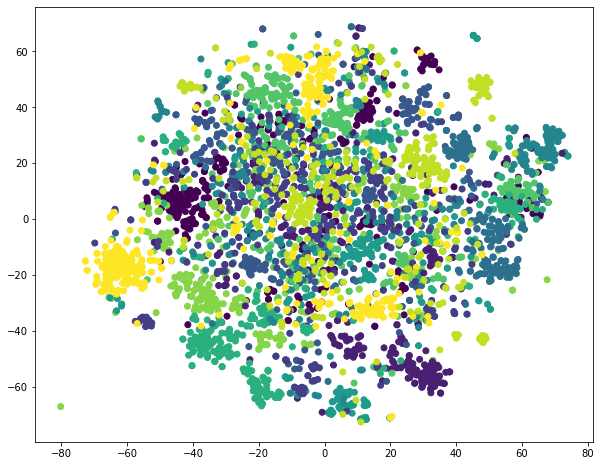

In [88]:
plt.figure(figsize = (10, 8))
plt.scatter(tsne_emb[:, 0], tsne_emb[:, 1], c = sent_df.categ_id.values);

## Similarity matrix (Word2vec)

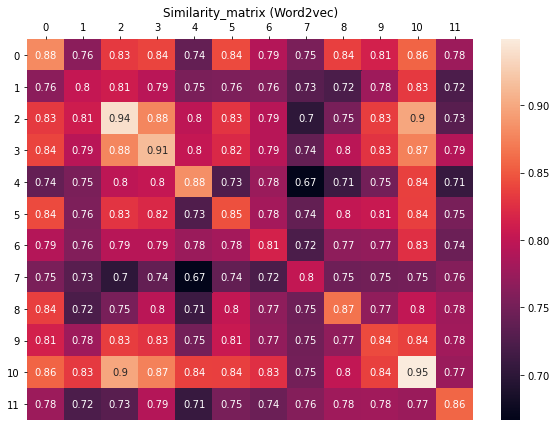

In [108]:
sim_matrix_word2vec = np.empty(shape = (12, 12))

for i in range(12):
    for j in range(12):
        sim_matrix_word2vec[i][j] = documents_similarity(i, j, 'word2vec_emb')
        
plt.figure(figsize = (10, 7))
ax = sn.heatmap(sim_matrix_word2vec, annot = True)

plt.yticks(rotation=0)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
plt.title('Similarity_matrix (Word2vec)')
plt.show()

In [109]:
embeddings = np.array(list(map(list, sent_df['word2vec_emb'].values)))
print(embeddings.shape)
tsne = TSNE(n_components=2)
tsne_emb = tsne.fit_transform(embeddings)

(4008, 300)


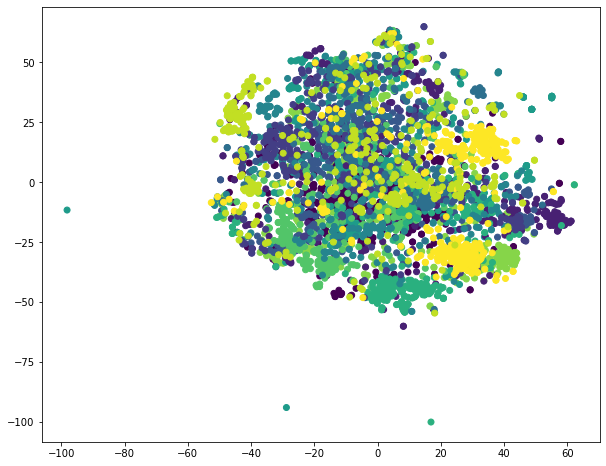

In [110]:
plt.figure(figsize = (10, 8))
plt.scatter(tsne_emb[:, 0], tsne_emb[:, 1], c = sent_df.categ_id.values);

## Mean Differences

In [105]:
mean_differences_doc2vec = np.empty(shape = 12)
mean_differences_sent_transf = np.empty(shape = 12)
mean_differences_word2vec = np.empty(shape = 12)

for i in range(12):
    mean_differences_doc2vec[i] = np.mean([sim_matrix_doc2vec[i][i] - sim_matrix_doc2vec[i][j] 
                                           for j in range(12) if i != j])
    mean_differences_sent_transf[i] = np.mean([sim_matrix_sent_transf[i][i] - sim_matrix_sent_transf[i][j] 
                                               for j in range(12) if i != j])
    mean_differences_word2vec[i] = np.mean([sim_matrix_word2vec[i][i] - sim_matrix_word2vec[i][j] 
                                            for j in range(12) if i != j])

In [107]:
pd.DataFrame({'categ_id': np.arange(12), 'mean_diff_doc2vec': mean_differences_doc2vec,
              'mean_diff_sent_transf': mean_differences_sent_transf, 'mean_diff_word2vec': mean_differences_word2vec,
              'inter_categ_sim_doc2vec': [sim_matrix_doc2vec[i][i] for i in range(12)], 
              'inter_categ_sim_sent_transf': [sim_matrix_sent_transf[i][i] for i in range(12)],
              'inter_categ_sim_word2vec': [sim_matrix_word2vec[i][i] for i in range(12)]})

,categ_id,mean_diff_doc2vec,mean_diff_sent_transf,mean_diff_word2vec,inter_categ_sim_doc2vec,inter_categ_sim_sent_transf,inter_categ_sim_word2vec
0,0,0.261419,0.154942,0.075849,0.451118,0.837986,0.880229
1,1,0.245853,0.073322,0.036791,0.451537,0.681372,0.802777
2,2,0.275142,0.173561,0.134390,0.492605,0.878163,0.939905
3,3,0.350340,0.163781,0.099976,0.518307,0.830869,0.914279
4,4,0.416094,0.169362,0.131781,0.561454,0.711115,0.883593
5,5,0.299635,0.096471,0.055021,0.536618,0.747843,0.845331
6,6,0.229183,0.088979,0.039283,0.368366,0.692472,0.814500
7,7,0.206803,0.099262,0.069310,0.320376,0.670545,0.801984
8,8,0.326220,0.131410,0.094384,0.431415,0.778379,0.865470
9,9,0.279557,0.106736,0.049973,0.467535,0.762239,0.842172
